# This is a tutorial of using scDHMap on a simulated dataset

The simulated dataset was generated by "splatter_simulation_dropout.R" with the setting dropout_mid = 2.5.

This tutorial was implemented on Intel(R) Core(TM) i9-10920X CPU @ 3.50GHz and NVIDIA(R) GeForce(TM) RTX 3090 GPU.

Setup parameters.

In [1]:
import math, os
from time import time

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from scDHMap import scDHMap
from embedding_quality_score import get_quality_metrics
import numpy as np
import collections
from sklearn import metrics
from single_cell_tools import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import read_dataset, normalize, pearson_residuals

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'Splatter_simulate_1.h5'
        self.batch_size = 512
        self.select_genes = 1000
        self.n_PCA = 50
        self.pretrain_iter = 400
        self.maxiter = 5000
        self.minimum_iter = 0
        self.patience = 150
        self.lr = 1e-3
        self.alpha = 1000.
        self.beta = 10.
        self.prob = 0
        self.perplexity = [30.]
        self.ae_weights = None
        self.ae_weights_file = 'AE_weights.pth.tar'
        self.save_dir = 'ES_model/'
        self.pretrain_latent_file = 'ae_latent.txt'
        self.final_latent_file = 'final_latent.txt'
        self.device = 'cuda'
        
args = Args()

Read data. X is the matrix of raw counts, and X_true is the matrix of true counts. True counts are used for evaluating embedding quality here.

In [4]:
data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X'])
x_true = np.array(data_mat['X_true'])
data_mat.close()

importantGenes = geneSelection(x, n=args.select_genes, plot=False)
x = x[:, importantGenes]
x_true = x_true[:, importantGenes]

# preprocessing scRNA-seq read counts matrix
adata0 = sc.AnnData(x)

adata = read_dataset(adata0,
                 transpose=False,
                 test_split=False,
                 copy=True)

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

X_normalized = pearson_residuals(x, theta=100)
X_true_normalized = pearson_residuals(x_true, theta=100)

X_pca = PCA(n_components=args.n_PCA, svd_solver='full').fit_transform(X_normalized)
X_true_pca = PCA(n_components=args.n_PCA, svd_solver='full').fit_transform(X_true_normalized)

print(args)

print(x.shape)
print(x_true.shape)
print(X_pca.shape)
print(X_true_pca.shape)

Chosen offset: 2.68
### Autoencoder: Successfully preprocessed 1000 genes and 4000 cells.
(4000, 1000)
(4000, 1000)
(4000, 50)
(4000, 50)


Build the model.

In [5]:
model = scDHMap(input_dim=adata.n_vars, encodeLayer=[128, 64, 32, 16], decodeLayer=[16, 32, 64, 128], 
        batch_size=args.batch_size, activation="elu", z_dim=2, alpha=args.alpha, beta=args.beta, 
        perplexity=args.perplexity, prob=args.prob, device=args.device).to(args.device)

print(str(model))

scDHMap(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4

Pretrain model.

In [6]:
'''
Pretrain model
'''
t0 = time()
if args.ae_weights is None:
    model.pretrain_autoencoder(adata.X.astype(np.float64), adata.raw.X.astype(np.float64), adata.obs.size_factors.astype(np.float64), 
        lr=args.lr, pretrain_iter=args.pretrain_iter, ae_save=True, ae_weights=args.ae_weights_file)
else:
    if os.path.isfile(args.ae_weights):
        print("==> loading checkpoint '{}'".format(args.ae_weights))
        checkpoint = torch.load(args.ae_weights)
        model.load_state_dict(checkpoint['ae_state_dict'])
    else:
        print("==> no checkpoint found at '{}'".format(args.ae_weights))
        raise ValueError
print('Pretraining time: %d seconds.' % int(time() - t0))

Pretraining stage
Pretraining epoch 1, Total loss:25059.77671704, ZINB loss:25058.86561821, KLD loss:0.91109882
Pretraining epoch 2, Total loss:21252.71263600, ZINB loss:21251.75049114, KLD loss:0.96214486
Pretraining epoch 3, Total loss:16797.59715475, ZINB loss:16796.68065008, KLD loss:0.91650467
Pretraining epoch 4, Total loss:12779.10021761, ZINB loss:12778.24452294, KLD loss:0.85569467
Pretraining epoch 5, Total loss:9716.37925504, ZINB loss:9715.52292570, KLD loss:0.85632934
Pretraining epoch 6, Total loss:7679.42435322, ZINB loss:7678.53481315, KLD loss:0.88954007
Pretraining epoch 7, Total loss:6352.59814043, ZINB loss:6351.71892591, KLD loss:0.87921453
Pretraining epoch 8, Total loss:5545.19968666, ZINB loss:5544.25673099, KLD loss:0.94295567
Pretraining epoch 9, Total loss:5051.29271484, ZINB loss:5050.39632292, KLD loss:0.89639192
Pretraining epoch 10, Total loss:4751.17473848, ZINB loss:4750.25598989, KLD loss:0.91874858
Pretraining epoch 11, Total loss:4547.77635213, ZINB 

Pretraining epoch 89, Total loss:3334.29527548, ZINB loss:3333.03315797, KLD loss:1.26211751
Pretraining epoch 90, Total loss:3328.16312872, ZINB loss:3326.88446905, KLD loss:1.27865966
Pretraining epoch 91, Total loss:3324.04412299, ZINB loss:3322.76847295, KLD loss:1.27565005
Pretraining epoch 92, Total loss:3320.84916894, ZINB loss:3319.61276565, KLD loss:1.23640329
Pretraining epoch 93, Total loss:3318.22018664, ZINB loss:3316.94869201, KLD loss:1.27149462
Pretraining epoch 94, Total loss:3312.42281104, ZINB loss:3311.11702815, KLD loss:1.30578289
Pretraining epoch 95, Total loss:3310.14803998, ZINB loss:3308.86652132, KLD loss:1.28151866
Pretraining epoch 96, Total loss:3305.65769218, ZINB loss:3304.34613532, KLD loss:1.31155686
Pretraining epoch 97, Total loss:3302.46776809, ZINB loss:3301.15266101, KLD loss:1.31510707
Pretraining epoch 98, Total loss:3294.48063958, ZINB loss:3293.17461777, KLD loss:1.30602181
Pretraining epoch 99, Total loss:3292.60856884, ZINB loss:3291.2941351

Pretraining epoch 177, Total loss:3101.80994345, ZINB loss:3099.85278604, KLD loss:1.95715741
Pretraining epoch 178, Total loss:3103.03732272, ZINB loss:3101.03532114, KLD loss:2.00200158
Pretraining epoch 179, Total loss:3102.44501051, ZINB loss:3100.45094896, KLD loss:1.99406154
Pretraining epoch 180, Total loss:3099.93179660, ZINB loss:3097.91294070, KLD loss:2.01885590
Pretraining epoch 181, Total loss:3098.84073248, ZINB loss:3096.83313821, KLD loss:2.00759427
Pretraining epoch 182, Total loss:3094.45768231, ZINB loss:3092.44511945, KLD loss:2.01256286
Pretraining epoch 183, Total loss:3094.99545044, ZINB loss:3092.97062205, KLD loss:2.02482839
Pretraining epoch 184, Total loss:3094.07174479, ZINB loss:3092.03268327, KLD loss:2.03906153
Pretraining epoch 185, Total loss:3093.43668361, ZINB loss:3091.41089216, KLD loss:2.02579146
Pretraining epoch 186, Total loss:3090.35132611, ZINB loss:3088.29431600, KLD loss:2.05701011
Pretraining epoch 187, Total loss:3087.15693511, ZINB loss:3

Pretraining epoch 265, Total loss:3016.46776611, ZINB loss:3013.72493461, KLD loss:2.74283150
Pretraining epoch 266, Total loss:3013.93048091, ZINB loss:3011.19772576, KLD loss:2.73275515
Pretraining epoch 267, Total loss:3012.90994592, ZINB loss:3010.16411119, KLD loss:2.74583474
Pretraining epoch 268, Total loss:3013.11260342, ZINB loss:3010.34336229, KLD loss:2.76924114
Pretraining epoch 269, Total loss:3015.46197570, ZINB loss:3012.70359747, KLD loss:2.75837823
Pretraining epoch 270, Total loss:3016.39014571, ZINB loss:3013.62159145, KLD loss:2.76855426
Pretraining epoch 271, Total loss:3013.85656534, ZINB loss:3011.05317698, KLD loss:2.80338836
Pretraining epoch 272, Total loss:3013.59890231, ZINB loss:3010.81945670, KLD loss:2.77944561
Pretraining epoch 273, Total loss:3010.22455313, ZINB loss:3007.43436629, KLD loss:2.79018684
Pretraining epoch 274, Total loss:3008.30180365, ZINB loss:3005.49860859, KLD loss:2.80319506
Pretraining epoch 275, Total loss:3010.05700924, ZINB loss:3

Pretraining epoch 354, Total loss:2969.70931459, ZINB loss:2966.33644087, KLD loss:3.37287373
Pretraining epoch 355, Total loss:2970.67741927, ZINB loss:2967.26695545, KLD loss:3.41046382
Pretraining epoch 356, Total loss:2970.59629210, ZINB loss:2967.17906797, KLD loss:3.41722413
Pretraining epoch 357, Total loss:2968.33351037, ZINB loss:2964.90073881, KLD loss:3.43277156
Pretraining epoch 358, Total loss:2968.46985476, ZINB loss:2965.05887576, KLD loss:3.41097901
Pretraining epoch 359, Total loss:2966.82089541, ZINB loss:2963.41409942, KLD loss:3.40679598
Pretraining epoch 360, Total loss:2966.45108925, ZINB loss:2963.01205226, KLD loss:3.43903700
Pretraining epoch 361, Total loss:2968.15512213, ZINB loss:2964.70280861, KLD loss:3.45231352
Pretraining epoch 362, Total loss:2966.65419742, ZINB loss:2963.19972416, KLD loss:3.45447326
Pretraining epoch 363, Total loss:2968.59097788, ZINB loss:2965.12055133, KLD loss:3.47042655
Pretraining epoch 364, Total loss:2969.68014393, ZINB loss:2

In [7]:
ae_latent = model.encodeBatch(torch.tensor(adata.X).double().to(args.device)).data.cpu().numpy()
QM_ae = get_quality_metrics(X_true_pca, ae_latent, distance='P')

np.savetxt(args.pretrain_latent_file, ae_latent, delimiter=",")

Poincaré space
Ranking: time = 2.5 sec
Rank high
Ranking: time = 2.1 sec
Rank low
Co-ranking: time = 16.55 sec
Qlocal = 0.39, Q_global = 0.72, Kmax = 671
Time = 8.36 sec


Train model with the t-SNE regularization.

In [8]:
'''
Train model with TSNE
'''
t0 = time()
model.train_model(adata.X.astype(np.float64), adata.raw.X.astype(np.float64), adata.obs.size_factors.astype(np.float64), X_pca.astype(np.float64), X_true_pca.astype(np.float64),
                lr=args.lr, maxiter=args.maxiter, minimum_iter=args.minimum_iter,
                patience=args.patience, save_dir=args.save_dir)
print('Training time: %d seconds.' % int(time() - t0))

Training...
Training epoch 1, Total loss:8693.15471314, ZINB loss:3014.39539715, t-SNE loss:5.64339849, KLD loss:3.53608286
Training epoch 2, Total loss:8564.06711151, ZINB loss:2973.18471840, t-SNE loss:5.55631855, KLD loss:3.45638401
Training epoch 3, Total loss:8486.84712711, ZINB loss:2950.21753201, t-SNE loss:5.50135919, KLD loss:3.52704061
Training epoch 4, Total loss:8436.42261969, ZINB loss:2943.70987922, t-SNE loss:5.45496989, KLD loss:3.77428497
Training epoch 5, Total loss:8387.30547657, ZINB loss:2933.86676364, t-SNE loss:5.41337410, KLD loss:4.00646133
Training epoch 6, Total loss:8354.90611104, ZINB loss:2929.84413264, t-SNE loss:5.38288373, KLD loss:4.21782521
Training epoch 7, Total loss:8319.77572714, ZINB loss:2928.49989032, t-SNE loss:5.34686754, KLD loss:4.44082952
Training epoch 8, Total loss:8293.19838610, ZINB loss:2926.34781094, t-SNE loss:5.31991985, KLD loss:4.69307280
Training epoch 9, Total loss:8280.08592747, ZINB loss:2923.69929990, t-SNE loss:5.30794673, 

Training epoch 72, Total loss:8083.12857878, ZINB loss:2852.21816646, t-SNE loss:5.16512969, KLD loss:6.57807197
Training epoch 73, Total loss:8084.83070495, ZINB loss:2854.96222710, t-SNE loss:5.16417271, KLD loss:6.56957686
Training epoch 74, Total loss:8094.98443509, ZINB loss:2864.08839249, t-SNE loss:5.16471577, KLD loss:6.61802687
Training epoch 75, Total loss:8095.41650230, ZINB loss:2865.42706407, t-SNE loss:5.16350018, KLD loss:6.64892538
Training epoch 76, Total loss:8089.60475154, ZINB loss:2858.75962030, t-SNE loss:5.16480134, KLD loss:6.60437931
Training epoch 77, Total loss:8088.70601225, ZINB loss:2858.14120186, t-SNE loss:5.16381384, KLD loss:6.67509681
Training epoch 78, Total loss:8089.48850346, ZINB loss:2858.81331504, t-SNE loss:5.16456685, KLD loss:6.61083388
Training epoch 79, Total loss:8090.78334223, ZINB loss:2858.07289172, t-SNE loss:5.16577907, KLD loss:6.69313818
Training epoch 80, Total loss:8093.62687902, ZINB loss:2858.43606283, t-SNE loss:5.16873829, KLD

Training epoch 142, Total loss:8055.47161816, ZINB loss:2832.55596338, t-SNE loss:5.15212652, KLD loss:7.07891394
Training epoch 143, Total loss:8055.00950786, ZINB loss:2829.99214498, t-SNE loss:5.15456670, KLD loss:7.04506654
Training epoch 144, Total loss:8059.97636874, ZINB loss:2838.16108931, t-SNE loss:5.15141985, KLD loss:7.03954326
Training epoch 145, Total loss:8057.44534057, ZINB loss:2833.23887044, t-SNE loss:5.15369550, KLD loss:7.05109713
Training epoch 146, Total loss:8056.26956173, ZINB loss:2832.68192850, t-SNE loss:5.15344578, KLD loss:7.01418529
Training epoch 147, Total loss:8053.62359415, ZINB loss:2831.47560994, t-SNE loss:5.15166175, KLD loss:7.04862387
Training epoch 148, Total loss:8055.15171699, ZINB loss:2833.28146545, t-SNE loss:5.15070548, KLD loss:7.11647687
Training epoch 149, Total loss:8059.43039154, ZINB loss:2836.66479306, t-SNE loss:5.15153544, KLD loss:7.12301568
Training epoch 150, Total loss:8057.03547970, ZINB loss:2835.09171444, t-SNE loss:5.1501

Training epoch 211, Total loss:8041.56986831, ZINB loss:2821.96631748, t-SNE loss:5.14629860, KLD loss:7.33049535
Training epoch 212, Total loss:8041.53008819, ZINB loss:2821.82595274, t-SNE loss:5.14653353, KLD loss:7.31706040
Training epoch 213, Total loss:8049.80483356, ZINB loss:2826.53920426, t-SNE loss:5.15056949, KLD loss:7.26961442
Training epoch 214, Total loss:8048.13475874, ZINB loss:2825.45295271, t-SNE loss:5.15001862, KLD loss:7.26631844
Training epoch 215, Total loss:8045.52970099, ZINB loss:2825.74389659, t-SNE loss:5.14730462, KLD loss:7.24811813
Training epoch 216, Total loss:8049.03993873, ZINB loss:2827.88733520, t-SNE loss:5.14890195, KLD loss:7.22506575
Training epoch 217, Total loss:8050.94309460, ZINB loss:2829.53971211, t-SNE loss:5.14914007, KLD loss:7.22633168
Training epoch 218, Total loss:8048.62851261, ZINB loss:2828.00263232, t-SNE loss:5.14809712, KLD loss:7.25287620
Training epoch 219, Total loss:8048.73891648, ZINB loss:2828.41900887, t-SNE loss:5.1478

Ranking: time = 2.5 sec
Rank high
Ranking: time = 2.2 sec
Rank low
Co-ranking: time = 16.66 sec
Qlocal = 0.63, Q_global = 0.82, Kmax = 288
Time = 7.84 sec
Training epoch 282, Total loss:8041.92546963, ZINB loss:2823.56592282, t-SNE loss:5.14472469, KLD loss:7.36348598
Training epoch 283, Total loss:8040.68123622, ZINB loss:2821.08528551, t-SNE loss:5.14584772, KLD loss:7.37482342
Training epoch 284, Total loss:8040.85545037, ZINB loss:2820.52853127, t-SNE loss:5.14625754, KLD loss:7.40693744
Training epoch 285, Total loss:8039.78183844, ZINB loss:2818.97016331, t-SNE loss:5.14723318, KLD loss:7.35784924
Training epoch 286, Total loss:8037.86658481, ZINB loss:2818.50205088, t-SNE loss:5.14589398, KLD loss:7.34705547
Training epoch 287, Total loss:8035.47553010, ZINB loss:2816.44324914, t-SNE loss:5.14531051, KLD loss:7.37217671
Training epoch 288, Total loss:8040.28943898, ZINB loss:2821.60689548, t-SNE loss:5.14503463, KLD loss:7.36479094
Training epoch 289, Total loss:8035.05830378, Z

Training epoch 352, Total loss:8033.41572818, ZINB loss:2815.25817138, t-SNE loss:5.14368515, KLD loss:7.44724085
Training epoch 353, Total loss:8037.08436644, ZINB loss:2818.04706241, t-SNE loss:5.14468051, KLD loss:7.43567929
Training epoch 354, Total loss:8032.20950396, ZINB loss:2815.38811422, t-SNE loss:5.14225356, KLD loss:7.45678279
Training epoch 355, Total loss:8030.68654847, ZINB loss:2813.94733805, t-SNE loss:5.14184369, KLD loss:7.48955190
Training epoch 356, Total loss:8029.62109081, ZINB loss:2812.70896274, t-SNE loss:5.14202012, KLD loss:7.48920058
Training epoch 357, Total loss:8028.98179560, ZINB loss:2811.88476134, t-SNE loss:5.14267343, KLD loss:7.44235996
Training epoch 358, Total loss:8025.31588894, ZINB loss:2809.64730699, t-SNE loss:5.14068613, KLD loss:7.49824521
Training epoch 359, Total loss:8029.23506106, ZINB loss:2810.67255655, t-SNE loss:5.14329263, KLD loss:7.52698780
Training epoch 360, Total loss:8026.35648629, ZINB loss:2809.47856512, t-SNE loss:5.1416

Training epoch 421, Total loss:8026.09908451, ZINB loss:2809.59217738, t-SNE loss:5.14098474, KLD loss:7.55221674
Training epoch 422, Total loss:8028.57551638, ZINB loss:2811.54087183, t-SNE loss:5.14217050, KLD loss:7.48641399
Training epoch 423, Total loss:8025.15633859, ZINB loss:2809.40219441, t-SNE loss:5.14007413, KLD loss:7.56800134
Training epoch 424, Total loss:8027.32219028, ZINB loss:2809.19345944, t-SNE loss:5.14272983, KLD loss:7.53989009
Training epoch 425, Total loss:8022.77656754, ZINB loss:2807.36915568, t-SNE loss:5.13985096, KLD loss:7.55564516
Training epoch 426, Total loss:8026.95626166, ZINB loss:2810.61209724, t-SNE loss:5.14070328, KLD loss:7.56408877
Training epoch 427, Total loss:8026.95882950, ZINB loss:2810.77682142, t-SNE loss:5.14098596, KLD loss:7.51960516
Training epoch 428, Total loss:8025.29601310, ZINB loss:2808.68367782, t-SNE loss:5.14121456, KLD loss:7.53977728
Training epoch 429, Total loss:8025.80334702, ZINB loss:2808.13637514, t-SNE loss:5.1422

Training epoch 490, Total loss:8024.33737584, ZINB loss:2806.37149157, t-SNE loss:5.14201565, KLD loss:7.59502299
Training epoch 491, Total loss:8023.31093047, ZINB loss:2807.28265148, t-SNE loss:5.14075675, KLD loss:7.52715324
Training epoch 492, Total loss:8021.87012790, ZINB loss:2807.09767565, t-SNE loss:5.13891025, KLD loss:7.58621983
Training epoch 493, Total loss:8026.27975313, ZINB loss:2809.69662427, t-SNE loss:5.14085164, KLD loss:7.57314864
Training epoch 494, Total loss:8022.95861283, ZINB loss:2807.46937251, t-SNE loss:5.13960021, KLD loss:7.58890326
Training epoch 495, Total loss:8026.42235557, ZINB loss:2809.91239048, t-SNE loss:5.14069718, KLD loss:7.58127810
Training epoch 496, Total loss:8028.44871396, ZINB loss:2809.44961911, t-SNE loss:5.14335287, KLD loss:7.56462297
Training epoch 497, Total loss:8023.02822470, ZINB loss:2806.20987071, t-SNE loss:5.14077355, KLD loss:7.60448039
Training epoch 498, Total loss:8022.11693854, ZINB loss:2806.73047956, t-SNE loss:5.1396

Training epoch 561, Total loss:8020.51114081, ZINB loss:2804.28419915, t-SNE loss:5.14004111, KLD loss:7.61858273
Poincaré space
Ranking: time = 2.4 sec
Rank high
Ranking: time = 2.4 sec
Rank low
Co-ranking: time = 17.84 sec
Qlocal = 0.62, Q_global = 0.82, Kmax = 266
Time = 7.54 sec
Training epoch 562, Total loss:8021.71905713, ZINB loss:2805.73465967, t-SNE loss:5.13972937, KLD loss:7.62550276
Training epoch 563, Total loss:8019.65288895, ZINB loss:2803.55914259, t-SNE loss:5.13961864, KLD loss:7.64751025
Training epoch 564, Total loss:8018.84462804, ZINB loss:2802.65783186, t-SNE loss:5.14009151, KLD loss:7.60952900
Training epoch 565, Total loss:8018.69557741, ZINB loss:2803.40922120, t-SNE loss:5.13867052, KLD loss:7.66158312
Training epoch 566, Total loss:8021.28783715, ZINB loss:2805.59045410, t-SNE loss:5.13921681, KLD loss:7.64805770
Training epoch 567, Total loss:8021.17402179, ZINB loss:2804.66607527, t-SNE loss:5.14002466, KLD loss:7.64832887
Training epoch 568, Total loss:8

Training epoch 630, Total loss:8020.81424041, ZINB loss:2803.51641470, t-SNE loss:5.14039393, KLD loss:7.69038960
Training epoch 631, Total loss:8018.44013649, ZINB loss:2803.37815185, t-SNE loss:5.13854031, KLD loss:7.65216772
Training epoch 632, Total loss:8023.61206480, ZINB loss:2806.16864901, t-SNE loss:5.14003798, KLD loss:7.74054325
Training epoch 633, Total loss:8019.31874709, ZINB loss:2804.19160184, t-SNE loss:5.13833961, KLD loss:7.67875313
Training epoch 634, Total loss:8021.42644070, ZINB loss:2804.40472022, t-SNE loss:5.14027321, KLD loss:7.67485080
Training epoch 635, Total loss:8022.18173124, ZINB loss:2805.71625825, t-SNE loss:5.13961080, KLD loss:7.68546756
Training epoch 636, Total loss:8022.75489807, ZINB loss:2805.42917365, t-SNE loss:5.14097819, KLD loss:7.63475345
Training epoch 637, Total loss:8018.45908394, ZINB loss:2802.58377626, t-SNE loss:5.13964095, KLD loss:7.62343586
Training epoch 638, Total loss:8020.24329698, ZINB loss:2803.47108336, t-SNE loss:5.1401

Training epoch 699, Total loss:8019.04088767, ZINB loss:2802.98259449, t-SNE loss:5.13890048, KLD loss:7.71578180
Training epoch 700, Total loss:8017.07961212, ZINB loss:2801.42777777, t-SNE loss:5.13870280, KLD loss:7.69490312
Training epoch 701, Total loss:8016.09355093, ZINB loss:2800.78529797, t-SNE loss:5.13808757, KLD loss:7.72206824
Training epoch 702, Total loss:8015.74404740, ZINB loss:2799.99607687, t-SNE loss:5.13881272, KLD loss:7.69352466
Training epoch 703, Total loss:8016.71712288, ZINB loss:2800.13583845, t-SNE loss:5.13952059, KLD loss:7.70606973
Training epoch 704, Total loss:8018.06279152, ZINB loss:2800.48181233, t-SNE loss:5.13997646, KLD loss:7.76045168
Training epoch 705, Total loss:8021.44201730, ZINB loss:2803.94857839, t-SNE loss:5.14065538, KLD loss:7.68380574
Training epoch 706, Total loss:8019.33235940, ZINB loss:2802.82713522, t-SNE loss:5.13991794, KLD loss:7.65872865
Training epoch 707, Total loss:8021.22857637, ZINB loss:2803.59675179, t-SNE loss:5.1410

Training epoch 768, Total loss:8016.39894412, ZINB loss:2800.56476634, t-SNE loss:5.13884564, KLD loss:7.69885407
Training epoch 769, Total loss:8018.08563573, ZINB loss:2801.00906652, t-SNE loss:5.14016957, KLD loss:7.69070006
Training epoch 770, Total loss:8016.13598214, ZINB loss:2800.68884929, t-SNE loss:5.13824237, KLD loss:7.72047619
Training epoch 771, Total loss:8016.31579367, ZINB loss:2800.07661267, t-SNE loss:5.13902322, KLD loss:7.72159605
Training epoch 772, Total loss:8013.93354552, ZINB loss:2799.06876533, t-SNE loss:5.13784690, KLD loss:7.70178765
Training epoch 773, Total loss:8015.85767140, ZINB loss:2800.47186506, t-SNE loss:5.13844052, KLD loss:7.69452895
Training epoch 774, Total loss:8015.65720168, ZINB loss:2800.66365871, t-SNE loss:5.13763549, KLD loss:7.73580523
Training epoch 775, Total loss:8014.99939454, ZINB loss:2800.03144786, t-SNE loss:5.13786219, KLD loss:7.71057519
Training epoch 776, Total loss:8016.23657273, ZINB loss:2800.91691274, t-SNE loss:5.1380

Training epoch 839, Total loss:8015.18562479, ZINB loss:2800.67970201, t-SNE loss:5.13718823, KLD loss:7.73176952
Training epoch 840, Total loss:8014.12567305, ZINB loss:2799.05294366, t-SNE loss:5.13775565, KLD loss:7.73170841
Training epoch 841, Total loss:8013.60612377, ZINB loss:2798.49227123, t-SNE loss:5.13786640, KLD loss:7.72474492
Poincaré space
Ranking: time = 2.3 sec
Rank high
Ranking: time = 2.4 sec
Rank low
Co-ranking: time = 17.86 sec
Qlocal = 0.62, Q_global = 0.82, Kmax = 261
Time = 7.14 sec
Training epoch 842, Total loss:8015.14650455, ZINB loss:2798.88468995, t-SNE loss:5.13851782, KLD loss:7.77439975
Training epoch 843, Total loss:8014.57709997, ZINB loss:2798.90985132, t-SNE loss:5.13846064, KLD loss:7.72066080
Training epoch 844, Total loss:8017.38563127, ZINB loss:2800.02319261, t-SNE loss:5.14036066, KLD loss:7.70017752
Training epoch 845, Total loss:8016.33962840, ZINB loss:2799.78534448, t-SNE loss:5.13962109, KLD loss:7.69331929
Training epoch 846, Total loss:8

Training epoch 908, Total loss:8011.60036387, ZINB loss:2796.49178159, t-SNE loss:5.13754213, KLD loss:7.75664491
Training epoch 909, Total loss:8014.19103163, ZINB loss:2797.89503982, t-SNE loss:5.13885920, KLD loss:7.74367880
Training epoch 910, Total loss:8012.84712392, ZINB loss:2798.08619180, t-SNE loss:5.13728219, KLD loss:7.74787418
Training epoch 911, Total loss:8014.38472344, ZINB loss:2798.15401038, t-SNE loss:5.13847588, KLD loss:7.77548294
Training epoch 912, Total loss:8013.49226445, ZINB loss:2798.25080982, t-SNE loss:5.13773133, KLD loss:7.75101216
Training epoch 913, Total loss:8013.71709691, ZINB loss:2797.30045377, t-SNE loss:5.13853864, KLD loss:7.78780049
Training epoch 914, Total loss:8013.11127378, ZINB loss:2797.25740724, t-SNE loss:5.13842466, KLD loss:7.74292103
Training epoch 915, Total loss:8011.90802467, ZINB loss:2797.17012756, t-SNE loss:5.13742672, KLD loss:7.73111775
Training epoch 916, Total loss:8012.28776665, ZINB loss:2797.83359165, t-SNE loss:5.1373

Training epoch 977, Total loss:8012.43142451, ZINB loss:2797.62608221, t-SNE loss:5.13725235, KLD loss:7.75529973
Training epoch 978, Total loss:8013.73770411, ZINB loss:2797.55806880, t-SNE loss:5.13857168, KLD loss:7.76079582
Training epoch 979, Total loss:8014.10517348, ZINB loss:2798.83427363, t-SNE loss:5.13750704, KLD loss:7.77638639
Training epoch 980, Total loss:8012.49963351, ZINB loss:2798.10465455, t-SNE loss:5.13699562, KLD loss:7.73993541
Training epoch 981, Total loss:8011.96541066, ZINB loss:2796.90191304, t-SNE loss:5.13732467, KLD loss:7.77388259
EarlyStopping: run 980 iteration
Training time: 1222 seconds.


In [9]:
final_latent = model.encodeBatch(torch.tensor(adata.X).double().to(args.device)).data.cpu().numpy()
QM_ae = get_quality_metrics(X_true_pca, final_latent, distance='P')

np.savetxt(args.final_latent_file, final_latent, delimiter=",")

Poincaré space
Ranking: time = 2.7 sec
Rank high
Ranking: time = 2.3 sec
Rank low
Co-ranking: time = 18.76 sec
Qlocal = 0.62, Q_global = 0.82, Kmax = 255
Time = 7.74 sec


## Embedding plot in R

Plot the embedding after pretrain.

In [1]:
rm(list = ls())
library(ggplot2)
library(ggforce)

In [2]:
load("./True_trajectory_1.RData")

colorvector <- c("#e6194b", "#3cb44b", "#ffe119", "#0082c8", 
                 "#f58231", "#911eb4", "#46f0f0", "#f032e6",
                 "#d2f53c", "#fabebe", "#008080", "#e6beff",
                 "#aa6e28", "#fffac8", "#800000", "#aaffc3")

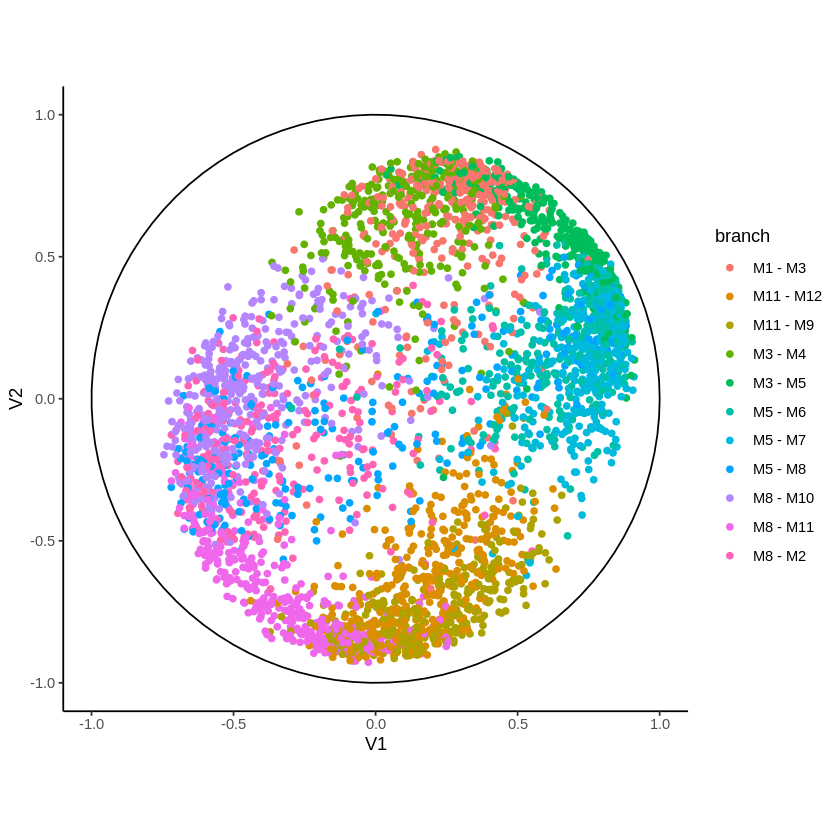

In [3]:
'''
Draw pretrain embedding 
'''
latent <- read.table("ae_latent.txt", sep=",")
dat <- data.frame(latent, branch=paste(progressions$from, progressions$to, sep=" - "))
ggplot(dat, aes(x=V1, y=V2, color=branch)) + geom_point() + 
        annotate("path", x=0+1*cos(seq(0,2*pi,length.out=100)),
                  y=0+1*sin(seq(0,2*pi,length.out=100))) +  
        theme_classic() + coord_fixed(ratio = 1)

Plot the embedding after train with the t-SNE regularization. We observed that after training, branches were mixed togethor, and after adding the t-SNE regularization, we can see clear branch structures.

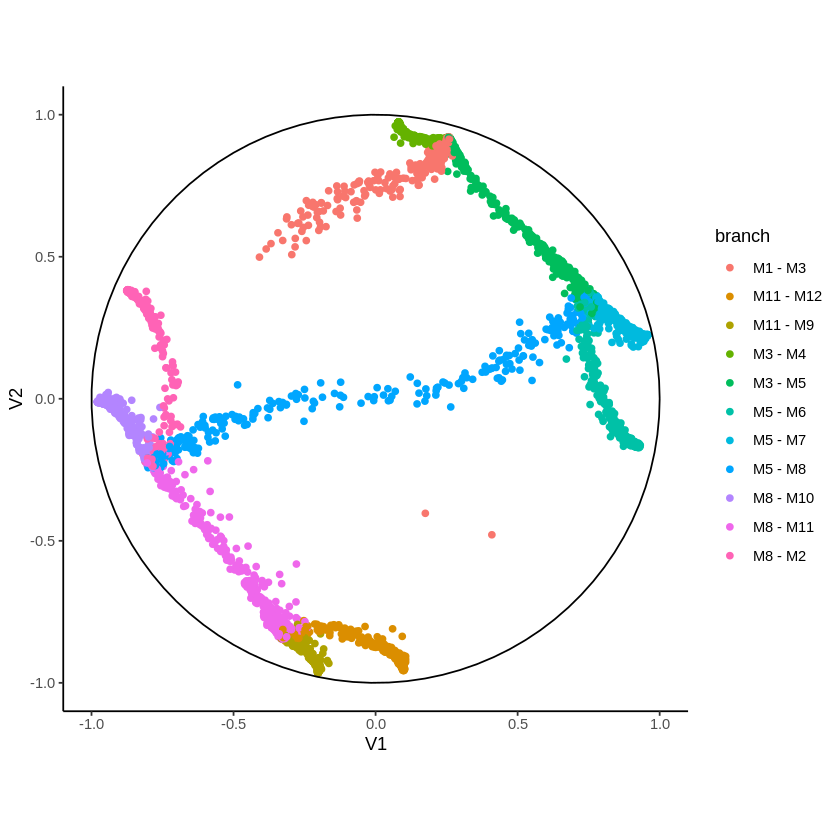

In [4]:
'''
Draw final embedding 
'''
latent <- read.table("final_latent.txt", sep=",")
dat <- data.frame(latent, branch=paste(progressions$from, progressions$to, sep=" - "))
ggplot(dat, aes(x=V1, y=V2, color=branch)) + geom_point() + 
        annotate("path", x=0+1*cos(seq(0,2*pi,length.out=100)),
                         y=0+1*sin(seq(0,2*pi,length.out=100))) +
        theme_classic() + coord_fixed(ratio = 1)